In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import networkx as nx
import matplotlib.pyplot as plt

import gc
import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from latentcor import latentcor
from gglasso.problem import glasso_problem
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Load data and preprocess
- Load all four species with their 5% and 1% gene coverage set and subsample to either mRNA or rRNA genes
- Filter out gene with no gene annotation
- Filter out cells containing no information in each set
- Converting genes to protein clusters (PCs) as index
- Assemble input for latentcor and gglasso inlcuding random subsampling per strain so each has the same number of observations

In [4]:
path_data = "../data/preprocessed/preprocessed_new/preprocessed/"

In [5]:
strain_names = ["ec", "efm", "psa", "kp"]
strains_gc5_mRNA = {}
strains_gc1_mRNA = {}
strains_gc5_rRNA = {}
strains_gc1_rRNA = {}

for strain in strain_names:
    mudata = md.read(path_data + strain + "_mudata_preprocessed.h5mu")
    gc5 = mudata["gc5_genes"].copy()
    gc1 = mudata["gc1_genes"].copy()

    gc5_mRNA = gc5[:, ~gc5.var["rRNA"]].copy()
    gc1_mRNA = gc1[:, ~gc1.var["rRNA"]].copy()
    gc5_rRNA = gc5[:, gc5.var["rRNA"]].copy()
    gc1_rRNA = gc1[:, gc1.var["rRNA"]].copy()

    #remove genes that have no gene annotation
    gc5_mRNA = gc5_mRNA[:, gc5_mRNA.var["matchin_protein"] == "match"]
    gc1_mRNA = gc1_mRNA[:, gc1_mRNA.var["matchin_protein"] == "match"]
    gc5_rRNA = gc5_rRNA[:, gc5_rRNA.var["matchin_protein"] == "match"]
    gc1_rRNA = gc1_rRNA[:, gc1_rRNA.var["matchin_protein"] == "match"]

    sc.pp.filter_cells(gc5_mRNA, min_counts=1, inplace=True)
    sc.pp.filter_cells(gc1_mRNA, min_counts=1, inplace=True)
    sc.pp.filter_cells(gc5_rRNA, min_counts=1, inplace=True)
    sc.pp.filter_cells(gc1_rRNA, min_counts=1, inplace=True)
        
    strains_gc5_mRNA[strain] = gc5_mRNA
    strains_gc1_mRNA[strain] = gc1_mRNA
    strains_gc5_rRNA[strain] = gc5_rRNA
    strains_gc1_rRNA[strain] = gc1_rRNA

print(strains_gc5_mRNA.keys())
print(strains_gc1_mRNA.keys())
print(strains_gc5_rRNA.keys())
print(strains_gc1_rRNA.keys())

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name be

dict_keys(['ec', 'efm', 'psa', 'kp'])
dict_keys(['ec', 'efm', 'psa', 'kp'])
dict_keys(['ec', 'efm', 'psa', 'kp'])
dict_keys(['ec', 'efm', 'psa', 'kp'])


In [6]:
print("Dimensions of gc5_mRNA sets: ", [strain.shape for strain in list(strains_gc5_mRNA.values())])
print("Dimensions of gc1_mRNA sets: ", [strain.shape for strain in list(strains_gc1_mRNA.values())])
print("Dimensions of gc5_rRNA sets: ", [strain.shape for strain in list(strains_gc5_rRNA.values())])
print("Dimensions of gc1_rRNA sets: ", [strain.shape for strain in list(strains_gc1_rRNA.values())])

Dimensions of gc5_mRNA sets:  [(2405, 24), (4657, 33), (172, 19), (646, 18)]
Dimensions of gc1_mRNA sets:  [(2497, 203), (4707, 242), (188, 314), (742, 152)]
Dimensions of gc5_rRNA sets:  [(2428, 28), (4321, 25), (98, 9), (650, 23)]
Dimensions of gc1_rRNA sets:  [(2446, 41), (4456, 43), (146, 39), (680, 43)]


Load the initial dataset containing the protein cluster information such that we can convert genes to protein clusters later on

In [8]:
path_nSBM = '../data/raw/mudata_nSBM_hierarchy_2_final.h5mu'
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

MuData object with n_obs × n_vars = 36469 × 33412
  3 modalities
    SC_genes:	36469 x 14009
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	36469 x 13687
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	36469 x 5716
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

Taking the lev6 (most aggregated and connected) protein clusters and translate genes of each strain into cluster \
Note, in adata its obs x var; now we transpose for gglasso

In [9]:
data_nSBM["SC_proteins"].varm["protein_hierarchy"]

,lev0,lev1,lev2,lev3,lev4,lev5,lev6,lev_root
NP_052605.1,lev00totlen16795,forDFlev16795,forDFlev26795,forDFlev36795,forDFlev46795,forDFlev56795,forDFlev66795,root
NP_052606.1,lev00totlen17549,forDFlev17549,forDFlev27549,forDFlev37549,forDFlev47549,forDFlev57549,forDFlev67549,root
NP_052608.1,lev00totlen15594,forDFlev15594,forDFlev25594,forDFlev35594,forDFlev45594,forDFlev55594,forDFlev65594,root
NP_052609.1,lev00totlen12063,forDFlev12063,forDFlev22063,forDFlev32063,forDFlev42063,forDFlev52063,forDFlev62063,root
NP_052610.1,lev00totlen1576,forDFlev1576,forDFlev2576,forDFlev3576,forDFlev4576,forDFlev5576,forDFlev6576,root
...,...,...,...,...,...,...,...,...
WP_004152553.1,lev00totlen14198,forDFlev14198,forDFlev24198,forDFlev34198,forDFlev44198,forDFlev54198,forDFlev64198,root
WP_004178188.1,lev00totlen11303,forDFlev11303,forDFlev21303,forDFlev31303,forDFlev41303,forDFlev51303,forDFlev61303,root
WP_228131004.1,lev00totlen11253,forDFlev11253,forDFlev21253,forDFlev31253,forDFlev41253,forDFlev51253,forDFlev61253,root
WP_228131000.1,lev020totlen21057,forDFlev11057,forDFlev21057,forDFlev31057,forDFlev41057,forDFlev51057,forDFlev61057,root


In [10]:
intersections_clusters_dict = {}

for name, dataset in zip(["gc5_mRNA", "gc1_mRNA", "gc5_rRNA", "gc1_rRNA"], [strains_gc5_mRNA, strains_gc1_mRNA, strains_gc5_rRNA, strains_gc1_rRNA]):

    intersec = set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[dataset["ec"].var["protein"]]["lev6"].values).intersection(
    set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[dataset["efm"].var["protein"]]["lev6"].values),
    set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[dataset["psa"].var["protein"]]["lev6"].values),
    set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[dataset["kp"].var["protein"]]["lev6"].values))
    
    intersections_clusters_dict[name] = intersec
    print(name, len(intersec))

gc5_mRNA 6
gc1_mRNA 30
gc5_rRNA 5
gc1_rRNA 30


In [11]:
intersections_clusters_dict["gc5_mRNA"]

{'forDFlev6183',
 'forDFlev62429',
 'forDFlev63405',
 'forDFlev6348',
 'forDFlev6543',
 'forDFlev6943'}

In [106]:
def create_S_and_all_obs(dictionary, N, intersection):
    S = []
    all_obs = dict()
    for idx, adata in enumerate(dictionary.values()):
        print(adata)
        obs = pd.DataFrame(index=data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[adata.var["protein"]]["lev6"].values,
                      data=adata.layers["sqrt_counts"].T.A)
        #downsample to N cells
        obs_sample = obs.sample(n=N, axis=1)
        #only take genes present in all strains
        obs_sample = obs_sample.loc[obs_sample.index.isin(intersection)]
        #aggregate ProtClusters
        obs_sample = obs_sample.groupby(obs_sample.index).sum()
        #calc latent correlations with latentcor
        tps = ["tru"] * obs_sample.shape[0]
        latent = latentcor(obs_sample.T, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=False)

        all_obs[idx] = pd.DataFrame(index=obs_sample.index,
                                columns=range(N),
                                data=obs_sample.values)
        
        S.append(latent["R"].to_numpy())
        print("dim of S and all_obs entry:", S[idx].shape, all_obs[idx].shape)

    return np.array(S), all_obs 


Although for one species the amount of cells is really now so we cannot leverage the higher counts for the other strains

In [13]:
Ns = {"gc5_mRNA": min([adata.shape[0] for adata in list(strains_gc5_mRNA.values())]),
      "gc1_mRNA": min([adata.shape[0] for adata in list(strains_gc1_mRNA.values())]),
      "gc5_rRNA": min([adata.shape[0] for adata in list(strains_gc5_rRNA.values())]),
      "gc1_rRNA": min([adata.shape[0] for adata in list(strains_gc1_rRNA.values())])}
Ns

{'gc5_mRNA': 172, 'gc1_mRNA': 188, 'gc5_rRNA': 98, 'gc1_rRNA': 146}

In [11]:
S_gc5_mRNA, all_obs_gc5_mRNA = create_S_and_all_obs(strains_gc5_mRNA, Ns["gc5_mRNA"], intersections_clusters_dict["gc5_mRNA"])

dim of S and all_obs entry: (6, 6) (6, 172)
dim of S and all_obs entry: (6, 6) (6, 172)
dim of S and all_obs entry: (6, 6) (6, 172)
dim of S and all_obs entry: (6, 6) (6, 172)


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


In [12]:
S_gc5_mRNA.shape

(4, 6, 6)

In [13]:
P = glasso_problem(S=S_gc5_mRNA, N=Ns["gc5_mRNA"], reg_params={"lambda1": 0.05, "lambda2": 0.05}, latent=False, do_scaling=False)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'lambda2': 0.05, 'mu1': None}


In [14]:
l1 = np.logspace(0,-4,20)
l2 = np.logspace(0,-4,20)
modelselect_params = {'lambda1_range' : l1, 'lambda2_range': l2}

P.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.1, tol=1e-7, rtol=1e-7)
print(P.reg_params)

ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminate

Text(0.5, 1.0, 'KP precision matrix')

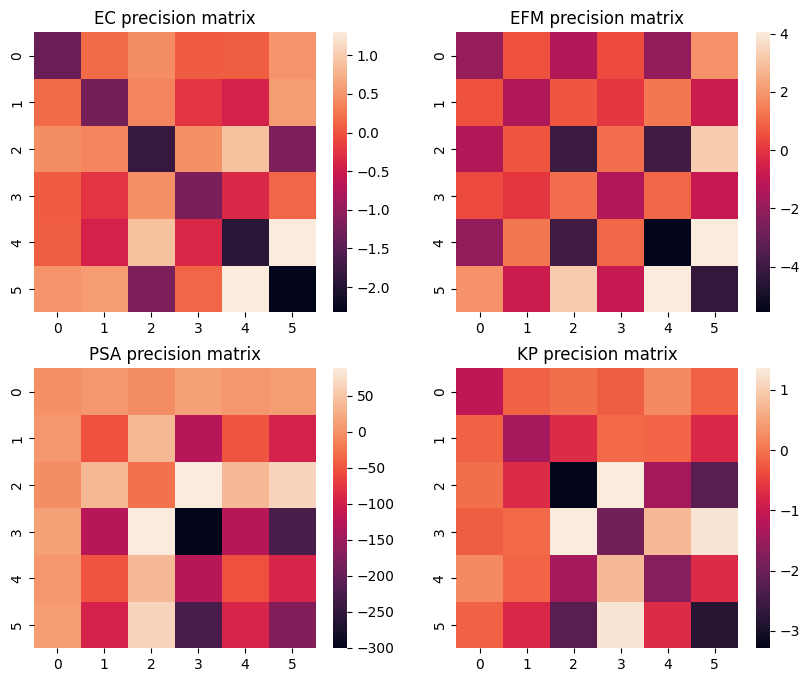

In [15]:
#draw 1
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.heatmap(P.solution.precision_[0] * -1, ax=axes[0,0])
sns.heatmap(P.solution.precision_[1] * -1, ax=axes[0,1])
sns.heatmap(P.solution.precision_[2] * -1, ax=axes[1,0])
sns.heatmap(P.solution.precision_[3] * -1, ax=axes[1,1])

axes[0, 0].set_title('EC precision matrix')
axes[0, 1].set_title('EFM precision matrix')
axes[1, 0].set_title('PSA precision matrix')
axes[1, 1].set_title('KP precision matrix')

In [26]:
[0 in np.sum(strain.X.A, axis=0) for strain in strains_gc1_mRNA.values()]

[False, False, False, False]

In [110]:
S_gc1_mRNA, all_obs_gc1_mRNA = create_S_and_all_obs(strains_gc1_mRNA, Ns["gc1_mRNA"], intersections_clusters_dict["gc1_mRNA"])

AnnData object with n_obs × n_vars = 2497 × 203
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'


/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


dim of S and all_obs entry: (30, 30) (30, 188)
AnnData object with n_obs × n_vars = 4707 × 242
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'


/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


dim of S and all_obs entry: (30, 30) (30, 188)
AnnData object with n_obs × n_vars = 188 × 314
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'


/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


dim of S and all_obs entry: (30, 30) (30, 188)
AnnData object with n_obs × n_vars = 742 × 152
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
dim of S and all_obs entry: (30, 30) (30, 188)


/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


In [111]:
from gglasso.helper.basic_linalg import scale_array_by_diagonal


S_gc1_mRNA = np.array([scale_array_by_diagonal(i) for i in S_gc1_mRNA])
S_gc1_mRNA.shape

(4, 30, 30)

In [112]:
P = glasso_problem(S=S_gc1_mRNA, N=Ns["gc1_mRNA"], reg_params={"lambda1": 0.05, "lambda2": 0.05}, latent=False, do_scaling=False)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'lambda2': 0.05, 'mu1': None}


In [113]:
l1 = np.logspace(0,-4,10)
l2 = np.logspace(0,-4,10)
modelselect_params = {'lambda1_range' : l1, 'lambda2_range': l2}

P.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.1, tol=1e-7, rtol=1e-7)
print(P.reg_params)

ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 33 iterations with status: optimal.
ADMM terminated after 33 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminate

In [141]:
"forDFlev61003"[8:]

'61003'

Text(0.5, 1.0, 'KP precision matrix')

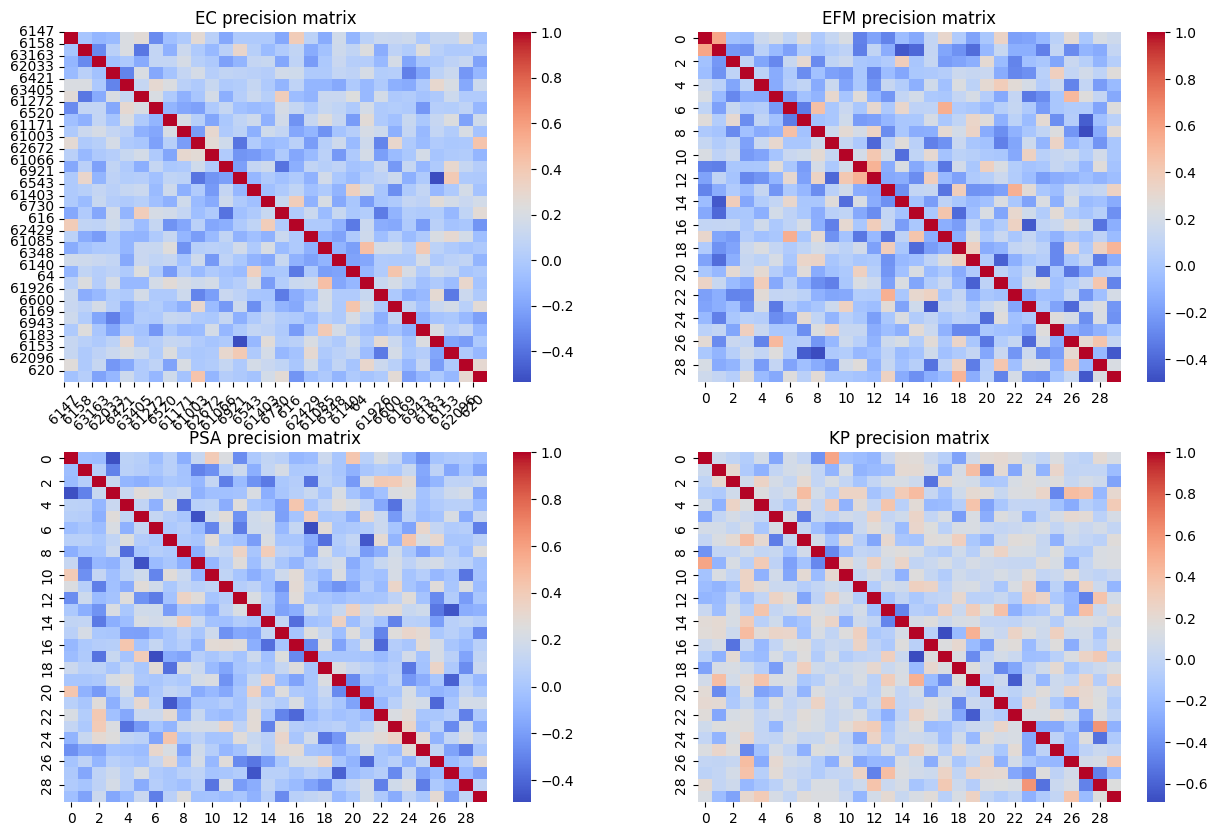

In [166]:
#draw 1
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

labels = [cluster[8:] for cluster in intersections_clusters_dict["gc1_mRNA"]]

sns.heatmap(scale_array_by_diagonal(P.solution.precision_[0]), ax=axes[0,0], cmap="coolwarm")
sns.heatmap(scale_array_by_diagonal(P.solution.precision_[1]), ax=axes[0,1], cmap="coolwarm")
sns.heatmap(scale_array_by_diagonal(P.solution.precision_[2]), ax=axes[1,0], cmap="coolwarm")
sns.heatmap(scale_array_by_diagonal(P.solution.precision_[3]), ax=axes[1,1], cmap="coolwarm")

axes[0, 0].set_title('EC precision matrix')
axes[0, 0].set_xticks(ticks=range(30), labels=labels, rotation=45)
axes[0, 0].set_yticks(ticks=range(30), labels=labels, rotation=0)
#axes[0, 0].set_xticklabels(labels=intersections_clusters_dict["gc1_mRNA"], rotation=30)
axes[0, 1].set_title('EFM precision matrix')
axes[1, 0].set_title('PSA precision matrix')
axes[1, 1].set_title('KP precision matrix')

In [121]:
all_obs_gc1_mRNA[0].index

Index(['forDFlev61003', 'forDFlev61066', 'forDFlev61085', 'forDFlev61171',
       'forDFlev61272', 'forDFlev6140', 'forDFlev61403', 'forDFlev6147',
       'forDFlev6153', 'forDFlev6158', 'forDFlev616', 'forDFlev6169',
       'forDFlev6183', 'forDFlev61926', 'forDFlev620', 'forDFlev62033',
       'forDFlev62096', 'forDFlev62429', 'forDFlev62672', 'forDFlev63163',
       'forDFlev63405', 'forDFlev6348', 'forDFlev64', 'forDFlev6421',
       'forDFlev6520', 'forDFlev6543', 'forDFlev6600', 'forDFlev6730',
       'forDFlev6921', 'forDFlev6943'],
      dtype='object')

In [122]:
intersections_clusters_dict["gc1_mRNA"]

{'forDFlev61003',
 'forDFlev61066',
 'forDFlev61085',
 'forDFlev61171',
 'forDFlev61272',
 'forDFlev6140',
 'forDFlev61403',
 'forDFlev6147',
 'forDFlev6153',
 'forDFlev6158',
 'forDFlev616',
 'forDFlev6169',
 'forDFlev6183',
 'forDFlev61926',
 'forDFlev620',
 'forDFlev62033',
 'forDFlev62096',
 'forDFlev62429',
 'forDFlev62672',
 'forDFlev63163',
 'forDFlev63405',
 'forDFlev6348',
 'forDFlev64',
 'forDFlev6421',
 'forDFlev6520',
 'forDFlev6543',
 'forDFlev6600',
 'forDFlev6730',
 'forDFlev6921',
 'forDFlev6943'}

In [95]:
strains_gc1_mRNA["ec"].var.loc[]

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,protein_name,rRNA,PC_lev0,PC_lev1,PC_lev2,PC_lev3,PC_lev4,PC_lev5,PC_lev6,log1p_mean_counts,log1p_total_counts,n_counts
cds-NP_308032.1,GSM5456505_PsA_CDS,match,NP_308032.1,42,0.016753,98.324691,42.0,49,NP_308032.1 hypothetical protein ECs_0005 [Esc...,False,lev00totlen13644,forDFlev13644,forDFlev23644,forDFlev33644,forDFlev43644,forDFlev53644,forDFlev63644,0.016614,3.761200,42.0
cds-NP_308056.1,GSM5456505_PsA_CDS,match,NP_308056.1,86,0.035899,96.569605,90.0,155,NP_308056.1 isoleucyl-tRNA synthetase [Escheri...,False,lev028totlen41003,forDFlev11003,forDFlev21003,forDFlev31003,forDFlev41003,forDFlev51003,forDFlev61003,0.035270,4.510859,90.0
cds-NP_308086.1,GSM5456505_PsA_CDS,match,NP_308086.1,63,0.025529,97.487036,64.0,128,NP_308086.1 LPS assembly OM complex LptDE beta...,False,lev00totlen14464,forDFlev14464,forDFlev24464,forDFlev34464,forDFlev44464,forDFlev54464,forDFlev64464,0.025208,4.174387,64.0
cds-NP_308124.1,GSM5456505_PsA_CDS,match,NP_308124.1,28,0.011169,98.883127,28.0,62,NP_308124.1 cell division protein FtsQ [Escher...,False,lev00totlen1336,forDFlev1336,forDFlev2336,forDFlev3336,forDFlev4336,forDFlev5336,forDFlev6336,0.011107,3.367296,28.0
cds-NP_308126.1,GSM5456505_PsA_CDS,match,NP_308126.1,38,0.015158,98.484244,38.0,65,NP_308126.1 GTP-binding tubulin-like cell divi...,False,lev00totlen12108,forDFlev12108,forDFlev22108,forDFlev32108,forDFlev42108,forDFlev52108,forDFlev62108,0.015044,3.663562,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_313242.1,GSM5456506_Kp_CDS,match,NP_313242.1,30,0.012365,98.803351,31.0,74,NP_313242.1 anaerobic ribonucleoside-triphosph...,False,lev00totlen12402,forDFlev12402,forDFlev22402,forDFlev32402,forDFlev42402,forDFlev52402,forDFlev62402,0.012290,3.465736,31.0
cds-NP_313246.1,GSM5456506_Kp_CDS,match,NP_313246.1,100,0.040686,96.011169,102.0,181,NP_313246.1 magnesium transporter [Escherichia...,False,lev052totlen3274,forDFlev1274,forDFlev2274,forDFlev3274,forDFlev4274,forDFlev5274,forDFlev6274,0.039880,4.634729,102.0
cds-NP_313262.1,GSM5456506_Kp_CDS,match,NP_313262.1,27,0.011169,98.923016,28.0,59,NP_313262.1 valyl-tRNA synthetase [Escherichia...,False,lev00totlen41003,forDFlev11003,forDFlev21003,forDFlev31003,forDFlev41003,forDFlev51003,forDFlev61003,0.011107,3.367296,28.0
cds-NP_313359.1,GSM5456506_Kp_CDS,match,NP_313359.1,29,0.012764,98.843239,32.0,48,NP_313359.1 pyrimidine 5'-nucleotidase [Escher...,False,lev00totlen11813,forDFlev11813,forDFlev21813,forDFlev31813,forDFlev41813,forDFlev51813,forDFlev61813,0.012683,3.496508,32.0


In [143]:
strains_gc1_mRNA["ec"].var.loc[strains_gc1_mRNA["ec"].var["PC_lev6"].isin(intersections_clusters_dict["gc1_mRNA"])]["protein_name"]

cds-NP_308056.1    NP_308056.1 isoleucyl-tRNA synthetase [Escheri...
cds-NP_308146.1    NP_308146.1 pyruvate dehydrogenase [Escherichi...
cds-NP_308147.1    NP_308147.1 dihydrolipoyl dehydrogenase [Esche...
cds-NP_308517.1    NP_308517.1 peptidyl-prolyl cis/trans isomeras...
cds-NP_308707.1    NP_308707.1 leucyl-tRNA synthetase [Escherichi...
                                         ...                        
cds-NP_312938.1    NP_312938.1 RNA polymerase beta prime subunit ...
cds-NP_313067.1    NP_313067.1 excinuclease ABC system protein Uv...
cds-NP_313138.1    NP_313138.1 lysine tRNA synthetase [Escherichi...
cds-NP_313151.1    NP_313151.1 molecular chaperone GroEL [Escheri...
cds-NP_313262.1    NP_313262.1 valyl-tRNA synthetase [Escherichia...
Name: protein_name, Length: 68, dtype: category
Categories (203, object): ['NP_308032.1 hypothetical protein ECs_0005 [Es..., 'NP_308056.1 isoleucyl-tRNA synthetase [Escher..., 'NP_308086.1 LPS assembly OM complex LptDE bet..., 'NP_308124.1 

In [96]:
strains_gc1_mRNA["ec"].var["PC_lev6"].isin(intersections_clusters_dict["gc1_mRNA"])

cds-NP_308032.1    False
cds-NP_308056.1     True
cds-NP_308086.1    False
cds-NP_308124.1    False
cds-NP_308126.1    False
                   ...  
cds-NP_313242.1    False
cds-NP_313246.1    False
cds-NP_313262.1     True
cds-NP_313359.1    False
cds-NP_313370.1    False
Name: PC_lev6, Length: 203, dtype: bool

In [159]:
" ".join(strains_gc1_mRNA["ec"].var.loc[strains_gc1_mRNA["ec"].var["PC_lev6"] == "forDFlev6147"]["protein_name"].values[0].split(" ")[1:])

'glyceraldehyde-3-phosphate dehydrogenase A [Escherichia coli O157:H7 str. Sakai]'

In [165]:
oi = dict()
for cluster in intersections_clusters_dict["gc1_mRNA"]:
    oi_tmp = strains_gc1_mRNA["ec"].var.loc[strains_gc1_mRNA["ec"].var["PC_lev6"] == cluster]["protein_name"].values
    oi[cluster] = [" ".join(name.split(" ")[1:]) for name in oi_tmp]
oi

{'forDFlev6147': ['glyceraldehyde-3-phosphate dehydrogenase A [Escherichia coli O157:H7 str. Sakai]'],
 'forDFlev6158': ['RNA polymerase sigma 70 factor RpoD [Escherichia coli O157:H7 str. Sakai]'],
 'forDFlev63163': ['phenylalanine tRNA synthetase beta subunit [Escherichia coli O157:H7 str. Sakai]'],
 'forDFlev62033': ['peptidyl-prolyl cis/trans isomerase [Escherichia coli O157:H7 str. Sakai]'],
 'forDFlev6421': ['threonyl-tRNA synthetase [Escherichia coli O157:H7 str. Sakai]'],
 'forDFlev63405': ['RNA polymerase beta subunit [Escherichia coli O157:H7 str. Sakai]'],
 'forDFlev61272': ['aspartyl-tRNA synthetase [Escherichia coli O157:H7 str. Sakai]',
  'lysine tRNA synthetase [Escherichia coli O157:H7 str. Sakai]',
  'lysine tRNA synthetase [Escherichia coli O157:H7 str. Sakai]'],
 'forDFlev6520': ['RNA chaperone and antiterminator [Escherichia coli O157:H7 str. Sakai]'],
 'forDFlev61171': ['polynucleotide phosphorylase/polyadenylase [Escherichia coli O157:H7 str. Sakai]',
  'transcrip

### GGLASSO

In [16]:
from gglasso.helper.ext_admm_helper import create_group_array, construct_indexer, check_G

In [93]:
ix_exist, ix_location = construct_indexer(list(all_obs.values()))

G = create_group_array(ix_exist, ix_location, min_inst=4)

check_G(G, len(intersection_genes))

Creation of bookeeping array...
10% finished
20% finished
30% finished
40% finished
50% finished
60% finished
70% finished
80% finished
90% finished


In [94]:
from gglasso.problem import glasso_problem

P = glasso_problem(S=S, N=N, reg="GGL", reg_params=None, latent=True, G=G, do_scaling=True)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': None, 'lambda2': None, 'mu1': None}


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\problem.py:254: UserWarning: NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!
  warnings.warn("NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\problem.py:255: UserWarning: The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.
  warnings.warn("The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.")


In [95]:
l1 =    np.logspace(0,-4,20)
mu1 =   np.logspace(1,-1,20)
l2 =    np.logspace(0,-4,20)

modelselect_params = {'lambda1_range' : l1, 'mu1_range': mu1, 'lambda2_range': l2}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1, tol = 1e-7, rtol = 1e-7)

print(P.reg_params)

------------Range search for instance 0------------
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated afte

Solution sparsity (ratio of nonzero entries): 
Instance 0:  0.9333333333333333
Instance 1:  1.0
Instance 2:  1.0
Instance 3:  1.0


Text(0.5, 1.0, 'Nonzero entries per group')

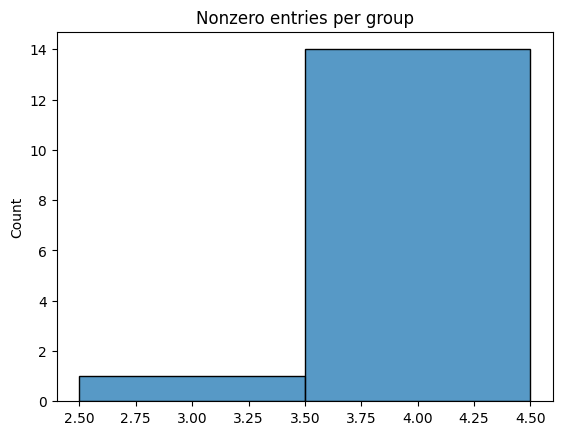

In [96]:
from gglasso.helper.ext_admm_helper import consensus
from gglasso.helper.utils import sparsity

print("Solution sparsity (ratio of nonzero entries): ")

for k in np.arange(4):
    print(f"Instance {k}: ", sparsity(P.solution.precision_[k]))

stats = P.modelselect_stats.copy()
nnz,_,_ = consensus(P.solution.precision_, G)

fig, ax = plt.subplots()
sns.histplot(nnz, discrete = True, ax = ax)
#ax.set_yscale('log')
ax.set_title('Nonzero entries per group')

Text(0.5, 1.0, 'KP precision matrix')

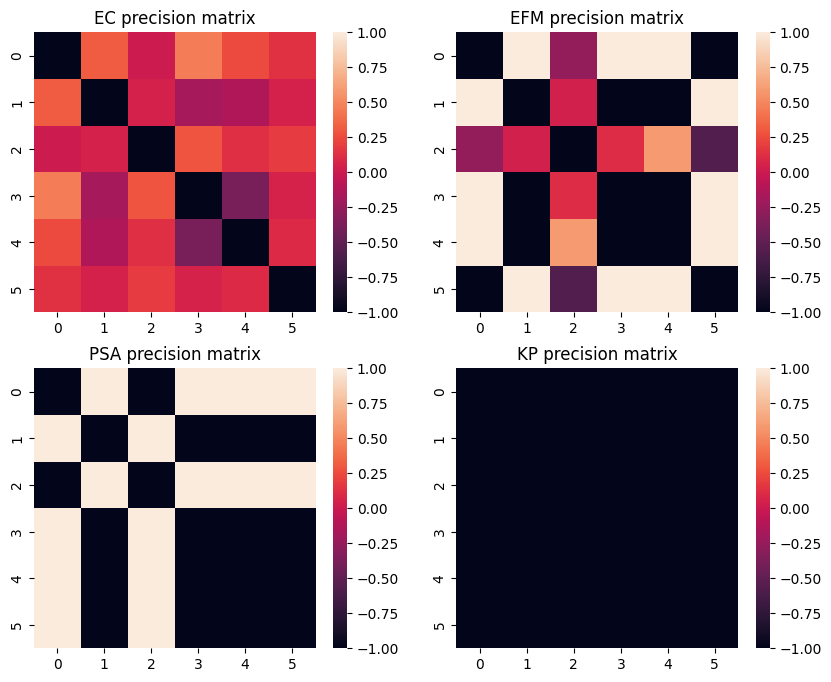

In [32]:
#draw 1
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.heatmap(P.solution.precision_[0] * -1, vmin=-1, vmax=1, ax=axes[0,0])
sns.heatmap(P.solution.precision_[1] * -1, vmin=-1, vmax=1, ax=axes[0,1])
sns.heatmap(P.solution.precision_[2] * -1, vmin=-1, vmax=1, ax=axes[1,0])
sns.heatmap(P.solution.precision_[3] * -1, vmin=-1, vmax=1, ax=axes[1,1])

axes[0, 0].set_title('EC precision matrix')
axes[0, 1].set_title('EFM precision matrix')
axes[1, 0].set_title('PSA precision matrix')
axes[1, 1].set_title('KP precision matrix')

Text(0.5, 1.0, 'KP precision matrix')

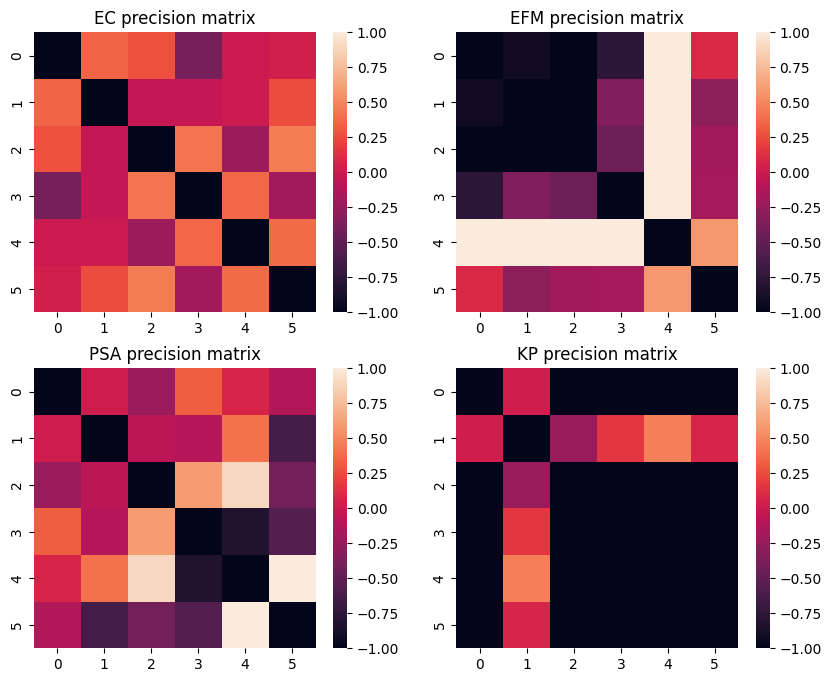

In [97]:
#draw 2
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.heatmap(P.solution.precision_[0] * -1, vmin=-1, vmax=1, ax=axes[0,0])
sns.heatmap(P.solution.precision_[1] * -1, vmin=-1, vmax=1, ax=axes[0,1])
sns.heatmap(P.solution.precision_[2] * -1, vmin=-1, vmax=1, ax=axes[1,0])
sns.heatmap(P.solution.precision_[3] * -1, vmin=-1, vmax=1, ax=axes[1,1])

axes[0, 0].set_title('EC precision matrix')
axes[0, 1].set_title('EFM precision matrix')
axes[1, 0].set_title('PSA precision matrix')
axes[1, 1].set_title('KP precision matrix')

In [74]:
condition = data_nSBM["SC_proteins"].varm["protein_hierarchy"]["lev6"].isin(intersection_genes)
genes = data_nSBM["SC_proteins"].varm["protein_hierarchy"].index[condition]

In [89]:
for i in ec_gc5.var.loc[ec_gc5.var["protein"].isin(genes)]["protein_name"].values:
    print(i)
print("__________")
for i in efm_gc5.var.loc[efm_gc5.var["protein"].isin(genes)]["protein_name"].values:
    print(i)
print("__________")
for i in psa_gc5.var.loc[psa_gc5.var["protein"].isin(genes)]["protein_name"].values:
    print(i)
print("__________")
for i in kp_gc5.var.loc[kp_gc5.var["protein"].isin(genes)]["protein_name"].values:
    print(i)

NP_312076.1 translation initiation factor IF-2 [Escherichia coli O157:H7 str. Sakai]
NP_312187.1 RNA polymerase alpha subunit [Escherichia coli O157:H7 str. Sakai]
NP_312192.1 preprotein translocase membrane subunit SecY [Escherichia coli O157:H7 str. Sakai]
NP_312217.1 translation elongation factor EF-Tu 1 [Escherichia coli O157:H7 str. Sakai]
NP_312218.1 protein chain elongation factor EF-G [Escherichia coli O157:H7 str. Sakai]
NP_312701.1 F0F1 ATP synthase subunit beta [Escherichia coli O157:H7 str. Sakai]
NP_312703.1 F0F1 ATP synthase subunit alpha [Escherichia coli O157:H7 str. Sakai]
NP_312930.1 translation elongation factor EF-Tu 1 [Escherichia coli O157:H7 str. Sakai]
NP_312937.1 RNA polymerase beta subunit [Escherichia coli O157:H7 str. Sakai]
NP_312938.1 RNA polymerase beta prime subunit [Escherichia coli O157:H7 str. Sakai]
__________
WP_002288141.1 MULTISPECIES: DNA-directed RNA polymerase subunit beta' [Enterococcus]
WP_002288688.1 MULTISPECIES: preprotein translocase subu